In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

print("Starting phishing email detection project\n")

Starting phishing email detection project



PART 1: DATA LOADING
Total number of emails: 18650
Columns: ['text', 'label']

First rows:
                                                text           label
0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email
1  the other side of * galicismos * * galicismo *...      Safe Email
2  re : equistar deal tickets are you still avail...      Safe Email
3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email
4  software at incredibly low prices ( 86 % lower...  Phishing Email

Missing values in 'text': 16

Class distribution:
label
0    11322
1     7328
Name: count, dtype: int64


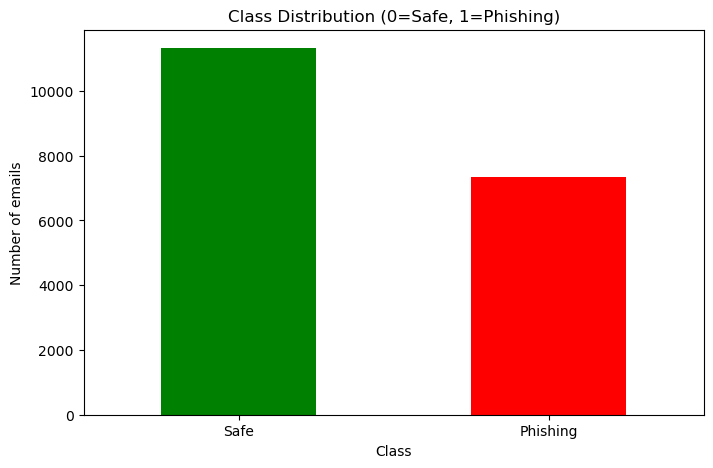

In [2]:
print("PART 1: DATA LOADING")
print("=" * 60)

# Charger le dataset
df = pd.read_csv("Phishing_Email.csv")

# Supprimer la colonne inutile
df = df.drop(columns=["Unnamed: 0"])

# Renommer les colonnes
df = df.rename(columns={"Email Text": "text", "Email Type": "label"})

print(f"Total number of emails: {len(df)}")
print(f"Columns: {list(df.columns)}")
print("\nFirst rows:")
print(df.head())

# Convertir les labels en 0 et 1
df["label"] = df["label"].map({"Safe Email": 0, "Phishing Email": 1})

# Vérifier les valeurs manquantes
print(f"\nMissing values in 'text': {df['text'].isna().sum()}")

# Distribution des classes
print("\nClass distribution:")
print(df["label"].value_counts())

# Visualiser la distribution
plt.figure(figsize=(8, 5))
df["label"].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Class Distribution (0=Safe, 1=Phishing)")
plt.xlabel("Class")
plt.ylabel("Number of emails")
plt.xticks([0, 1], ["Safe", "Phishing"], rotation=0)
plt.show()
print()

In [3]:
print("PART 2: DATA CLEANING")
print("=" * 60)

# Approche: Supprimer les lignes avec NaN (+ simple et efficace)
print(f"Size before cleaning: {len(df)}") #affiche la taille du dataset avant nettoyage
df_clean = df.dropna(subset=["text"]).copy() #supprime les lignes ou "text" est NaN + crée un nv DataFrame propre
print(f"Size after cleaning: {len(df_clean)}")#affiche la taille du dataset apres nettoyage
print(f"Removed rows: {len(df) - len(df_clean)}\n")

PART 2: DATA CLEANING
Size before cleaning: 18650
Size after cleaning: 18634
Removed rows: 16



In [4]:
print("PART 3: DATA PREPARATION")
print("=" * 60)

# Séparer en 2 parties
X = df_clean["text"] #1 partie pour les emails (qu'on va analyser)
y = df_clean["label"] #2e partie pour les réponses(0|1)

# On divise nos donnes en 2 grp
X_train, X_test, y_train, y_test = train_test_split(
    X, # Les emails (features)
    y, # Les labels (target)
    test_size=0.2, # 20% pour le test, 80% pour le train
    random_state=42, # Pour avoir toujours le même split
    stratify=y # Garde les mêmes proportions de 0 et 1
)

#Pour afficher la taille des train
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}\n")

# Vectorisation TF-IDF TF-IDF = Term Frequency - Inverse Document Frequency (C'est une façon intelligente de donner des scores aux mots)
print("TF-IDF vectorization...")
vectorizer = TfidfVectorizer(stop_words="english", #stop_words="english" : ignore les mots vides comme "the", "a", "is"
                             max_features=5000) # garde seulement les 5000 mots les plus importants

X_train_vec = vectorizer.fit_transform(X_train) #Transforme X_train en matrice TF-IDF
X_test_vec = vectorizer.transform(X_test) #Transforme X_test en matrice TF-IDF
print(f"TF-IDF matrix shape: {X_train_vec.shape}\n") #Affiche la forme de la matrice 

PART 3: DATA PREPARATION
Train size: 14907
Test size: 3727

TF-IDF vectorization...
TF-IDF matrix shape: (14907, 5000)



PART 4: BASELINE - LOGISTIC REGRESSION
Baseline model results:
Accuracy:  0.9632
Precision: 0.9402
Recall:    0.9679
F1-Score:  0.9538

Detailed report:
              precision    recall  f1-score   support

        Safe       0.98      0.96      0.97      2265
    Phishing       0.94      0.97      0.95      1462

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



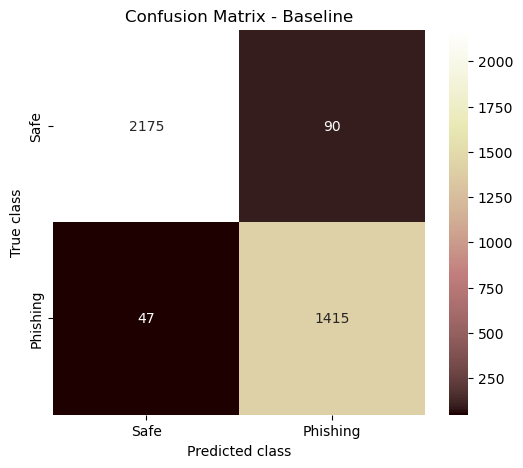

In [5]:
print("PART 4: BASELINE - LOGISTIC REGRESSION") # Modèle qui dessine une ligne pour séparer les deux classes (Safe vs Phishing).
print("=" * 60)
#objectif => trouver la meilleure ligne pour séparer les 2 groupes 
# Entraîner le modèle baseline
lr_baseline = LogisticRegression(max_iter=1000,#nb d'essais mac pour trouver la meilleure ligne
                                 random_state=42) #on fixe un point de départ pour sa ligne =résultats reproductibles
lr_baseline.fit(X_train_vec, y_train) # Entraîne le modèle sur les données d'entraînement

# Prédictions
y_pred_baseline = lr_baseline.predict(X_test_vec) #Fait des prédictions sur le test set(renvoie 0 ou 1 pour chaque email du test)

# Évaluation
print("Baseline model results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_baseline):.4f}") #% de prédictions correctes
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}") #Calcule et affiche la Precision : parmi les emails classés "phishing", combien sont vraiment du phishing
print(f"Recall:    {recall_score(y_test, y_pred_baseline):.4f}")#Calcule et affiche le Recall : parmi tous les vrais phishing, combien ont été détectés
print(f"F1-Score:  {f1_score(y_test, y_pred_baseline):.4f}")#Calcule et affiche le F1-Score : moyenne harmonique entre Precision et Recall

print("\nDetailed report:")#on affiche un "rapport"
print(classification_report(y_test, y_pred_baseline, 
                          target_names=["Safe", "Phishing"]))

# Matrice de confusion
cm_baseline = confusion_matrix(y_test, y_pred_baseline)#Calcule la matrice de confusion 
plt.figure(figsize=(6, 5))#Crée une figure de taille 6*5pouces
sns.heatmap(cm_baseline,  #Créer une headmap de la matrice de confusion
            annot=True, #affiche les nombres dans les cases
            fmt='d', #format entier (pas de décimales)
            cmap='pink', #couleur bleue
            xticklabels=["Safe", "Phishing"],
            yticklabels=["Safe", "Phishing"])
plt.title("Confusion Matrix - Baseline")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()
print()


In [6]:
print("PART 5: GRIDSEARCH - LOGISTIC REGRESSION") #On teste toutes les combinaisons 
print("=" * 60)

# Définir la grille de paramètres
param_grid_lr = {
    'C': [0.1, 1, 10],#force de régularisation (0.1= tres simple, ignore les petits détails, interessant si les données ont bcq de bruit)
                      #(1=modele quilibré et 10=modele complexe, suit +les données, interessant si les données sont propres)
    'penalty': ['l2'],#technique de régularisation l1=valeur absolule et l2=valeur au carré + prudent et féneraliste
    'solver': ['lbfgs', 'liblinear'] #solver=algorithme qui cherche la best solution (2 valeurs)
                                    # lbfgs=> utilise l'historique récent et liblinear=>coordonéees une par une 
}

# GridSearch
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5, #divise les données par 5
    scoring='f1', #scoring='f1' : optimise le F1-score
    n_jobs=-1 #utilise tous les CPU disponibles
)

#Lance la recherche des meilleurs paramètres : 
print("Searching for best parameters...")
grid_lr.fit(X_train_vec, y_train) #Entraîne 6 × 5 = 30 modèles (6 combos × 5 folds)

print(f"\nBest parameters: {grid_lr.best_params_}") # Affiche les meilleurs paramètres trouvés 
print(f"Best F1 score (CV): {grid_lr.best_score_:.4f}")

# Évaluer sur le test
lr_optimized = grid_lr.best_estimator_  #Récupère le meilleur modèle trouvé par GridSearch
y_pred_lr_opt = lr_optimized.predict(X_test_vec) #Fait des prédictions sur le test avec le modèle optimisé

print("\nOptimized model results:") #Affiche toutes les métriques du modèle optimisé sur le test
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr_opt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr_opt):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr_opt):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lr_opt):.4f}\n")
 

PART 5: GRIDSEARCH - LOGISTIC REGRESSION
Searching for best parameters...

Best parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1 score (CV): 0.9624

Optimized model results:
Accuracy:  0.9665
Precision: 0.9418
Recall:    0.9747
F1-Score:  0.9580



In [7]:
print("PART 6: GRIDSEARCH - DECISION TREE")
print("=" * 60)

# Grille de parametres
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, None], #jusqu'a ou l'arbre peut se diviser
    'min_samples_split': [2, 5], #combien de données il faut dans un noeud pour diviser
    'min_samples_leaf': [1, 2] #Combien de données minimum doit rester dans une feuille finale
}

#Création GridSearch
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

print("Searching for best parameters...")
grid_dt.fit(X_train_vec, y_train)

print(f"\nBest parameters: {grid_dt.best_params_}")
print(f"Best F1 score (CV): {grid_dt.best_score_:.4f}")

# Évaluer
dt_optimized = grid_dt.best_estimator_
y_pred_dt = dt_optimized.predict(X_test_vec)

print("\nDecision Tree results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_dt):.4f}\n")

PART 6: GRIDSEARCH - DECISION TREE
Searching for best parameters...

Best parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 score (CV): 0.8955

Decision Tree results:
Accuracy:  0.9195
Precision: 0.8792
Recall:    0.9213
F1-Score:  0.8998



In [8]:
print("PART 7: BAGGING CLASSIFIER") #au lieu de se contenter d'un seul modele, il en crée plusieurs et combine leurs résultats pour etre + robuste. 1 modele mais plusieurs versions
print("=" * 60)

# Bagging avec le meilleur LR
bagging_model = BaggingClassifier(
    estimator=lr_optimized,
    n_estimators=10, #nb de modele different
    random_state=42,
    n_jobs=-1
)

print("Training Bagging model...")
bagging_model.fit(X_train_vec, y_train)
y_pred_bagging = bagging_model.predict(X_test_vec) #Fait les predictions

print("\nBagging results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_bagging):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_bagging):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_bagging):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_bagging):.4f}\n")

PART 7: BAGGING CLASSIFIER
Training Bagging model...

Bagging results:
Accuracy:  0.9665
Precision: 0.9430
Recall:    0.9733
F1-Score:  0.9579



PART 8: VOTING CLASSIFIER
Training Voting Classifier...

Voting Classifier results:
Accuracy:  0.9665
Precision: 0.9430
Recall:    0.9733
F1-Score:  0.9579



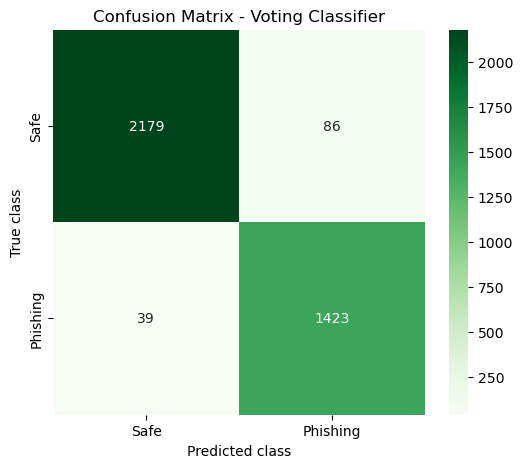

In [9]:
print("PART 8: VOTING CLASSIFIER") # plusieurs modeles different => vote 
print("=" * 60)

# Combiner les 3 modèles  : LR optimisé, DT optimisé, Bagging
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_optimized),
        ('dt', dt_optimized),
        ('bagging', bagging_model)
    ],
    voting='hard', #vote majoritaire (si 2/3 disent "phishing" => phishing)
    n_jobs=-1
)

print("Training Voting Classifier...")
voting_model.fit(X_train_vec, y_train) #Entraine le Voting Classifier
y_pred_voting = voting_model.predict(X_test_vec) #Fait des prédictions (vote des 3 modèles)

print("\nVoting Classifier results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_voting):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_voting):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_voting):.4f}\n")

# Matrice de confusion
cm_voting = confusion_matrix(y_test, y_pred_voting)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Greens',
            xticklabels=["Safe", "Phishing"],
            yticklabels=["Safe", "Phishing"])
plt.title("Confusion Matrix - Voting Classifier")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.show()
print()

PART 9: MODEL COMPARISON

Summary table:
        Model  Accuracy  Precision   Recall  F1-Score
  Baseline LR  0.963241   0.940199 0.967852  0.953825
 LR Optimized  0.966461   0.941837 0.974692  0.957983
Decision Tree  0.919506   0.879243 0.921341  0.899800
      Bagging  0.966461   0.943009 0.973324  0.957927
       Voting  0.966461   0.943009 0.973324  0.957927

Table saved: results_comparison.csv



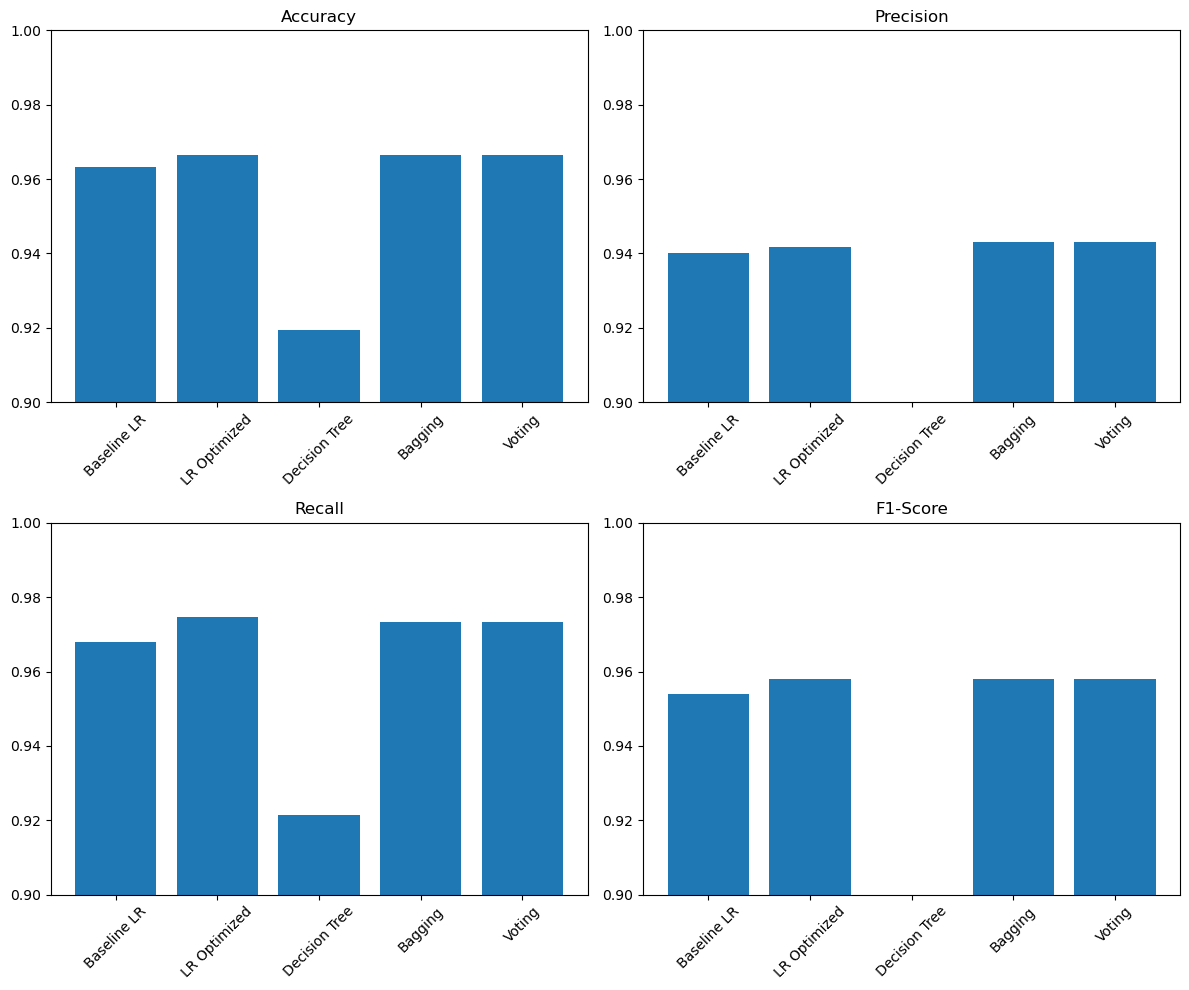

In [10]:
print("PART 9: MODEL COMPARISON")
print("=" * 60)

# Création un tableau de comparaison
results = {
    'Model': [ #crée un dictionnaire avec les noms des 5 modèles
        'Baseline LR',
        'LR Optimized',
        'Decision Tree',
        'Bagging',
        'Voting'
    ],
    'Accuracy': [ # Liste les Accuracy des 5 modèles
        accuracy_score(y_test, y_pred_baseline),
        accuracy_score(y_test, y_pred_lr_opt),
        accuracy_score(y_test, y_pred_dt),
        accuracy_score(y_test, y_pred_bagging),
        accuracy_score(y_test, y_pred_voting)
    ],
    'Precision': [ #Liste les Precision des 5 modèles
        precision_score(y_test, y_pred_baseline),
        precision_score(y_test, y_pred_lr_opt),
        precision_score(y_test, y_pred_dt),
        precision_score(y_test, y_pred_bagging),
        precision_score(y_test, y_pred_voting)
    ],
    'Recall': [ #Liste les Recall des 5 modèles
        recall_score(y_test, y_pred_baseline),
        recall_score(y_test, y_pred_lr_opt),
        recall_score(y_test, y_pred_dt),
        recall_score(y_test, y_pred_bagging),
        recall_score(y_test, y_pred_voting)
    ],
    'F1-Score': [ #Liste les F1-Score des 5 modèles
        f1_score(y_test, y_pred_baseline),
        f1_score(y_test, y_pred_lr_opt),
        f1_score(y_test, y_pred_dt),
        f1_score(y_test, y_pred_bagging),
        f1_score(y_test, y_pred_voting)
    ]
}

df_results = pd.DataFrame(results) # Convertit le dictionnaire en DataFrame
print("\nSummary table:")
print(df_results.to_string(index=False))

# Sauvegarder le tableau en csv 
df_results.to_csv("results_comparison.csv", index=False)
print("\nTable saved: results_comparison.csv\n")

# Graphique de comparaison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy
axes[0, 0].bar(df_results['Model'], df_results['Accuracy'])
axes[0, 0].set_title('Accuracy')
axes[0, 0].set_ylim([0.9, 1.0])
axes[0, 0].tick_params(axis='x', rotation=45)

# Precision
axes[0, 1].bar(df_results['Model'], df_results['Precision'])
axes[0, 1].set_title('Precision')
axes[0, 1].set_ylim([0.9, 1.0])
axes[0, 1].tick_params(axis='x', rotation=45)

# Recall
axes[1, 0].bar(df_results['Model'], df_results['Recall'])
axes[1, 0].set_title('Recall')
axes[1, 0].set_ylim([0.9, 1.0])
axes[1, 0].tick_params(axis='x', rotation=45)

# F1-Score
axes[1, 1].bar(df_results['Model'], df_results['F1-Score'])
axes[1, 1].set_title('F1-Score')
axes[1, 1].set_ylim([0.9, 1.0])
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
print()

In [13]:
print("CONCLUSION")
print("=" * 60)

best_idx = df_results['F1-Score'].idxmax()
best_model = df_results.loc[best_idx, 'Model']
best_f1 = df_results.loc[best_idx, 'F1-Score']

print(f"\nBest model: {best_model}")
print(f"F1-Score: {best_f1:.4f}")

CONCLUSION

Best model: LR Optimized
F1-Score: 0.9580
